In [2]:
import os
os.chdir('/home/fraza0/Desktop/MEI/TESE/nonverbal_communication_analysis')
print("Working Directory:", os.getcwd())
import ipywidgets as widgets

Working Directory: /home/fraza0/Desktop/MEI/TESE/nonverbal_communication_analysis


In [3]:
import pandas as pd
from pandas.io.json import json_normalize
import json
from pprint import pprint
import threading
from IPython.display import display
import ipywidgets as widgets
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2
from nonverbal_communication_analysis.environment import OPENFACE_OUTPUT_DIR, OPENPOSE_OUTPUT_DIR, VALID_OUTPUT_FILE_TYPES
from nonverbal_communication_analysis.utils import fetch_files_from_directory, filter_files

In [4]:
per_frame_metrics = {
    'n_people': 0,
    'valid_face_keypoints': 0,
    'total_valid_face_keypoints': 0,
    'valid_pose_keypoints': 0,
    'total_valid_pose_keypoints': 0,
}

vid_metrics = {}

In [5]:
groups_list = os.listdir(OPENPOSE_OUTPUT_DIR)

GROUP_ID = widgets.Dropdown(
    options=groups_list,
    value=groups_list[-1],
    description='Group:',
    disabled=False,
)
display(GROUP_ID)

Dropdown(description='Group:', index=3, options=('3CLC9VWR_output_OLD.tar.gz', 'walking_happy_output', 'walkin…

In [6]:
_dir = OPENPOSE_OUTPUT_DIR+GROUP_ID.value+"/output_pc1/"
input_files = [_dir+file for file in filter_files(fetch_files_from_directory([_dir]), valid_types = VALID_OUTPUT_FILE_TYPES)]
input_files.sort()
total_files = len(input_files)
print("Found: %s files" % total_files)

Found: 72178 files


In [7]:
CONFIDENCE_THRESHOLD = widgets.FloatSlider(
    value=0.55,
    min=0,
    max=1.0,
    step=0.05,
    description='Minimum Keypoint Confidence:',
    disabled=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)
display(CONFIDENCE_THRESHOLD)

FloatSlider(value=0.55, description='Minimum Keypoint Confidence:', max=1.0, readout_format='.1f', step=0.05)

In [8]:
def calculate_person_valid_keypoints(person_df):
    valid_person_pose_keypoints = 0
    person_entry = [person_df[x:x+3] for x in range(0, len(person_df), 3)]
    for pose_entry in person_entry:
        confidence = pose_entry[2]
        if confidence > CONFIDENCE_THRESHOLD.value:
            valid_person_pose_keypoints += 1
    return valid_person_pose_keypoints

In [9]:
%%time

counter = 0
for file in input_files[:]:
    per_frame_metrics = {}
    with open(file) as json_data:
        data = json.load(json_data)
        df = json_normalize(data['people'])
        per_frame_metrics['n_people'] = len(df['person_id'])
        per_frame_metrics['valid_face_keypoints'] = dict(df['face_keypoints_2d'].apply(calculate_person_valid_keypoints))
        per_frame_metrics['total_valid_face_keypoints'] = sum(per_frame_metrics['valid_face_keypoints'].values())
        per_frame_metrics['valid_pose_keypoints'] = dict(df['pose_keypoints_2d'].apply(calculate_person_valid_keypoints))
        per_frame_metrics['total_valid_pose_keypoints'] = sum(per_frame_metrics['valid_pose_keypoints'].values())
#         per_frame_metrics['pose_keypoints'] = df[]
        vid_metrics[counter] = per_frame_metrics
        json_data.close()
    counter += 1

CPU times: user 5min 46s, sys: 6.22 s, total: 5min 53s
Wall time: 17min 35s


## Simple Analysis of data consistency

In [10]:
num_people_time = [vid_metrics[frame_metrics]['n_people'] for frame_metrics in vid_metrics]
pose_keypoints_time = [vid_metrics[frame_metrics]['total_valid_pose_keypoints'] for frame_metrics in vid_metrics]
face_keypoints_time = [vid_metrics[frame_metrics]['total_valid_face_keypoints'] for frame_metrics in vid_metrics]

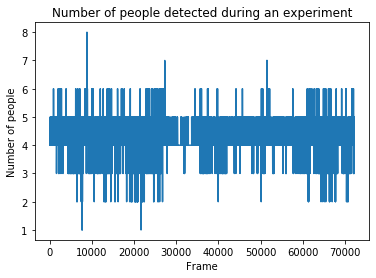

In [14]:
plt.plot(range(total_files), num_people_time)
plt.xlabel("Frame")
plt.ylabel("Number of people")
plt.title("Number of people detected during an experiment")
plt.show()

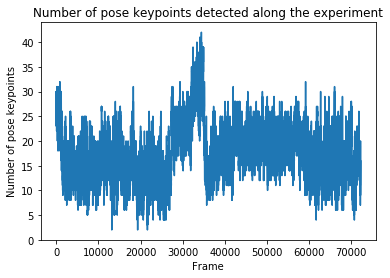

In [12]:
plt.plot(range(total_files), pose_keypoints_time)
plt.xlabel("Frame")
plt.ylabel("Number of pose keypoints")
plt.title("Number of pose keypoints detected along the experiment")
plt.show()

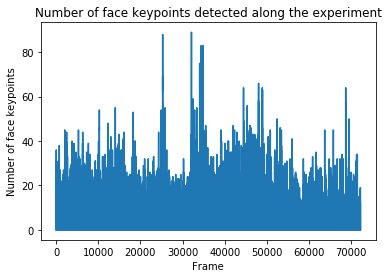

In [13]:
plt.plot(range(total_files), face_keypoints_time)
plt.xlabel("Frame")
plt.ylabel("Number of face keypoints")
plt.title("Number of face keypoints detected along the experiment")
plt.show()

## Pose-related

![Keypoints mapping](../../../images/keypoints_pose_25.png)

In [42]:
frame = df
frame.head()

,person_id,pose_keypoints_2d,face_keypoints_2d,hand_left_keypoints_2d,hand_right_keypoints_2d,pose_keypoints_3d,face_keypoints_3d,hand_left_keypoints_3d,hand_right_keypoints_3d
0,[-1],"[0.250026, -0.35372, 0.781029, 0.323207, -0.24...","[-1, -1, 0, -1, -1, 0, -1, -1, 0, -1, -1, 0, -...",[],[],[],[],[],[]
1,[-1],"[0.351141, -0.184913, 0.760542, 0.542582, -0.0...","[0.26782, 0.000362992, 0.0526649, 0.249429, -0...",[],[],[],[],[],[]
2,[-1],"[-0.314502, -0.320918, 0.420927, -0.443451, -0...","[-1, -1, 0, -1, -1, 0, -1, -1, 0, -1, -1, 0, -...",[],[],[],[],[],[]
3,[-1],"[-1, -1, 0, -1, -1, 0, -1, -1, 0, -1, -1, 0, -...","[-1, -1, 0, -1, -1, 0, -1, -1, 0, -1, -1, 0, -...",[],[],[],[],[],[]
4,[-1],"[-0.342408, -0.146884, 0.16709, -0.506138, -0....","[-1, -1, 0, -1, -1, 0, -1, -1, 0, -1, -1, 0, -...",[],[],[],[],[],[]


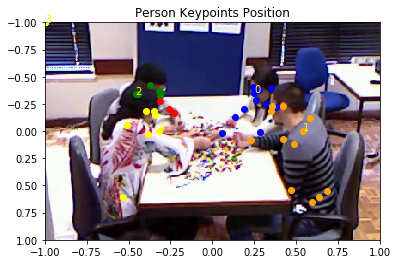

In [192]:
fig, ax = plt.subplots()
image = cv2.imread('/home/fraza0/Desktop/MEI/TESE/nonverbal_communication_analysis/DATASET_DEP/SYNC/3CLC9VWR/last_frame_vidpc1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# scaled_img = np.interp(image, (image.min(), image.max()), (-1, +1))
ax.set_xlim(-1, 1)
ax.set_ylim(1, -1)
ax.imshow(image, aspect='auto', extent=(-1,1,1,-1), alpha=1, zorder=-1)
colors = ['blue', 'orange', 'green', 'red', 'yellow']
for i in range(len(df['pose_keypoints_2d'])):
    ndf = pd.DataFrame(([frame['pose_keypoints_2d'][i][x:x+3] for x in range(0, len(frame['pose_keypoints_2d'][i]), 3)]), columns=['x', 'y', 'confidence'])
    ax.set_title('Person Keypoints Position')
    ax.scatter(ndf['x'], ndf['y'], c=colors[i])
    ax.annotate(i, (ndf['x'][i], ndf['y'][i]), c='yellow')

plt.show()